In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 선수들에 관한 데이터
players = pd.read_csv("england-premier-league-players-2018-to-2019-stats.csv")
# 경기 결과에 관한 데이터
matches = pd.read_csv("england-premier-league-matches-2018-to-2019-stats.csv")

매치결과를 이용한 분석

In [27]:
# 매치데이터를 이용한 분석 클래스 
class matches_anl:

  def __init__(self, matches):
    # 팀이름이 담기 데이터프레임
    self.matches = matches.copy()
    self.teams = self.matches['home_team_name'].sort_values()
    self.teams = self.teams.drop_duplicates().reset_index()
    self.teams = self.teams.drop(columns='index')
    self.teams = self.teams.rename(columns={'home_team_name':'Team'})

  # 승점으로 인한 순위표(같을경우 득실기준으로)
  def team_points(self):
    # 홈팀의 승점 합
    matches2 = self.matches.copy() # 복사본 생성
    # 홈팀과 어웨이팀의 득점을 비교하여 홈팀점수가 더 크면 3점, 어웨이팀이 더 크면 0점 같으면 1점을 부여한다
    matches2['home_team_points'] = np.where(matches2['home_team_goal_count'] > matches2['away_team_goal_count'], 3,
                                            np.where(matches2['home_team_goal_count'] == matches2['away_team_goal_count'], 1, 0))
    # home_team_name을 기준으로 홈팀 승점의 합을 구한다
    home_team_points = matches2.groupby('home_team_name')['home_team_points'].sum()

    # 어웨이 팀의 승점 합
    matches2['away_team_points'] = np.where(matches2['away_team_goal_count'] > matches2['home_team_goal_count'], 3,
                                            np.where(matches2['away_team_goal_count'] == matches2['home_team_goal_count'], 1, 0))
    # away_team_name을 기준으로 어웨이 팀 승점 합을 구한다
    away_team_points = matches2.groupby('away_team_name')['away_team_points'].sum()

    # home_team_points와 away_team_points는 시리즈형태, 정렬된상태이므로 팀이름 배치상태 일치
    # 바로 합해도된다
    teampoints = home_team_points + away_team_points
    # home_team_points의 이름을 Team으로 점수의 컬럼 이름을 0->Points로 변환
    teampoints = teampoints.to_frame()
    teampoints = teampoints.reset_index()
    teampoints = teampoints.rename(columns={'home_team_name':'Team',
                                              0:'Points'})
    #teampoints = teampoints.reset_index(drop=True)

    # 골 득실차를 가지는 복사본 데이터
    goaldif = self.teams.copy()
    goaldif
    matches2 = matches[['home_team_name', 'away_team_name','home_team_goal_count', 'away_team_goal_count']].copy()

    # 득점
    # 정렬한 기준으로 합해진 값 뺀 나머지 값들은 불필요한 의미없는 값이다
    homegoal = matches2.groupby('home_team_name').sum().reset_index()
    homegoal = homegoal.drop(columns = ['away_team_name', 'away_team_goal_count'])
    awaygoal = matches2.groupby('away_team_name').sum().reset_index()
    awaygoal = awaygoal.drop(columns = ['home_team_name', 'home_team_goal_count'])
    goaldif['Goal'] = homegoal['home_team_goal_count'] + awaygoal['away_team_goal_count']

    # 실점 : 경기 데이터의 상대팀(home팀의 경우 away팀의 // away팀의 경우 home팀의)득점이 본 팀의 실점
    # 홈팀 이름과 어웨이팀의 득점만 갖는 테이블을 만든다 -> 이 테이블은 홈팀의 실점을 의미한다
    homeagainst = matches[['home_team_name', 'away_team_goal_count']]
    homeagainst = homeagainst.groupby('home_team_name').sum().reset_index()
    # 반대로 어웨이팀의 실점 테이블 생성
    awayagainst = matches[['away_team_name', 'home_team_goal_count']]
    awayagainst = awayagainst.groupby('away_team_name').sum().reset_index()
    goaldif['Goal Against'] = homeagainst['away_team_goal_count'] + awayagainst['home_team_goal_count']

    # 득실차 행을 추가한다
    goaldif['GD'] = goaldif['Goal'] - goaldif['Goal Against']

    # 순위결정
    # 승점이 같다면 GD를 기준으로 오름차순한다
    # 승점 테이블에 GD테이블만을 붙인다
    # 승점과 GD를 기준으로 정렬한다 -> 승점이 같을 경우 GD를 기준으로 정렬
    gdtable = goaldif[['Team', 'GD']]
    teampoints = teampoints.merge(gdtable)
    teampoints = teampoints.sort_values(by=['Points', 'GD'], ascending = [False, False])
    teampoints = teampoints.reset_index(drop=True)
    teampoints = teampoints.reset_index()
    teampoints['Rank'] = teampoints['index'] + 1
    teampoints = teampoints.set_index('Rank')
    teampoints = teampoints.drop(columns='index')

    return teampoints

  # 각 팀의 주차별 승점, 득실차, 순위를 보여준다
  def team_rank_graph(self):
    # 주차별로 점수가 기록되어있다
    week_point = self.teams.copy()

    matches2 = self.matches[['home_team_name', 'away_team_name', 'Game Week','home_team_goal_count', 'away_team_goal_count']].copy()

    matches2['home_team_points'] = np.where(matches2['home_team_goal_count'] > matches2['away_team_goal_count'], 3,
                                            np.where(matches2['home_team_goal_count'] == matches2['away_team_goal_count'], 1, 0))

    matches2['away_team_points'] = np.where(matches2['away_team_goal_count'] > matches2['home_team_goal_count'], 3,
                                            np.where(matches2['away_team_goal_count'] == matches2['home_team_goal_count'], 1, 0))
    #matches2 = matches2.drop(columns=['home_team_goal_count', 'away_team_goal_count'])

    # 데이터의 Game Week는 중간에 못한 경기들을 다른날 한는 경우때문에 31주차가 35주차 사이에 껴있는등의 데이터가 존재한다
    # Game Week를 기준으로 정렬하여 해결한다
    matches2 = matches2.sort_values(by='Game Week', ascending=True)
    # 정렬한 상태여도 인덱스는 초기화된 상태가 아니라 원래 자기 인덱스를 가지고있는다
    # loc 슬라이싱을 하면 원래 인덱스이름,숫자로 접근하기때문에 정렬된 값순으로 나오지 않고 원래 순서대로 나오게된다.
    # 인덱스를 초기화 해준다
    matches2 = matches2.reset_index(drop=True)

    # 데이터에 승점, 득실차, 순위 추가
    for i in range(1, max(matches2['Game Week'])+1):
      week_data = pd.DataFrame({
        '{}week'.format(i) : [np.NaN]*len(self.teams),
        '{}week GD'.format(i) : [np.NaN]*len(self.teams),
        '{}week Rank'.format(i) : [0]*len(self.teams)
      })
      week_point = pd.concat([week_point, week_data], axis=1)

    week_point = week_point.set_index('Team')

    for i in range(len(matches2)):
      # 홈팀, 어웨이팀 이름
      hometeam = matches2.loc[i, 'home_team_name']
      awayteam = matches2.loc[i, 'away_team_name']

      # 홈팀 득실차: (홈팀 골 수 - 어웨이팀 골수) // 어웨이팀 득실차: (어웨이팀 골 수 - 홈팀 골 수)
      homegoal = matches2.loc[i, 'home_team_goal_count'] - matches2.loc[i, 'away_team_goal_count']
      awaygoal = matches2.loc[i, 'away_team_goal_count'] - matches2.loc[i, 'home_team_goal_count']

      # 홈팀, 어웨이팀 승점
      homepoint = matches2.loc[i, 'home_team_points']
      awaypoint = matches2.loc[i, 'away_team_points']

      # 주차별 승점, 득실차
      # 홈팀 득실차: (홈팀 골 수 - 어웨이팀 골수) // (어웨이팀 득실차: 어웨이팀 골 수 - 홈팀 골 수)
      # 1주차면 승점, 득실차를 그냥 집어넣는다
      week = matches2.loc[i, 'Game Week']
      if week == 1:
        # 홈팀 승점
        week_point.loc[hometeam, '{}week'.format(week)] = homepoint
        # 홈팀 득실차
        week_point.loc[hometeam, '{}week GD'.format(week)] = homegoal
        # 어웨이팀 승점
        week_point.loc[awayteam, '{}week'.format(week)] = awaypoint
        # 어웨이팀 득실차
        week_point.loc[awayteam, '{}week GD'.format(week)] = awaygoal

      # 2주차부터는 전주차의 값과 합한 값을 넣는다
      else:
        # 홈팀 승점
        week_point.loc[hometeam, '{}week'.format(week)] = homepoint + week_point.loc[hometeam, '{}week'.format(week-1)]
        # 홈팀 득실차
        week_point.loc[hometeam, '{}week GD'.format(week)] = homegoal + week_point.loc[hometeam, '{}week GD'.format(week-1)]
        # 어웨이팀 승점
        week_point.loc[awayteam, '{}week'.format(week)] = awaypoint + week_point.loc[awayteam, '{}week'.format(week-1)]
        # 어웨이팀 득실차
        week_point.loc[awayteam, '{}week GD'.format(week)] = awaygoal + week_point.loc[awayteam, '{}week GD'.format(week-1)]

    # 데이터의 타입을 정수형으로 바꿔준다
    week_point = week_point.astype('int') # : 주자별 승점, 득실차를 저장하고있는 데이터프레임

    week_point = week_point.reset_index()

    # 주차별순위추이를 그래프로 나타낸다
    # 승점과 득실차가 같을때 이름의 알파벳 순서대로 순위가 정해진다 -> 해결방법? : Rank 테이블을 추가한다 맨위에서부터 for믄 사용 1,2,3... 순위를 매긴다(for문  j의 값을 부여)
    # 맨 위가 1등 : 1을 부여한다, 두번재 데이터부터 위의 데이터와 비교한다. -> 같으면 위 데이터의  Rank값을 부여한다 (같은 값 부여) 다르면 j의 값을 부여
    week = self.teams.copy()
    for i in range(1, max(matches2['Game Week']+1)):
      weekrank = week_point[['Team','{}week'.format(i), '{}week GD'.format(i), '{}week Rank'.format(i)]]
      weekrank = weekrank.sort_values(by=['{}week'.format(i), '{}week GD'.format(i)], ascending=[False, False])
      weekrank = weekrank.reset_index(drop=True)
      for j in range(len(week_point)):
        if j == 0:
          weekrank.loc[j,'{}week Rank'.format(i)] = j+1
        elif weekrank.loc[ j,'{}week'.format(i)] == weekrank.loc[j-1,'{}week'.format(i)] and weekrank.loc[j,'{}week GD'.format(i)] == weekrank.loc[j-1,'{}week GD'.format(i)]:
          weekrank.loc[j,'{}week Rank'.format(i)] = weekrank.loc[j-1, '{}week Rank'.format(i)]
        else:
          weekrank.loc[j,'{}week Rank'.format(i)] = j+1
      weekrank = weekrank[['Team','{}week Rank'.format(i)]].sort_values('Team')
      # week데이터에 각 주차별 랭크를 합친다
      week = week.merge(weekrank, on='Team')

    print('no. Team Name')
    print('------------------------------')
    for i in range(len(self.teams)):
      print('{}. {}'.format(i+1, self.teams['Team'][i]))

    print('\n순위 추이를 확인하고 싶은 팀의 번호를 입력하세요.')
    n = int(input('팀 번호: '))

    # 팀목록은 1~20이므로 인덱스는 -1을 해야한다
    n_rank = week.loc[n-1].to_frame()

    # 데이터를 재정리한다 행은 week  열은 rank하여
    n_rank = n_rank[1:]
    n_rank = n_rank.reset_index(drop=True)
    n_rank = n_rank.reset_index()

    for i in range(len(n_rank)):
      n_rank.loc[i, 'index'] = i+1
    # n_rank의 순위가 저장된 칼럼의 이름은 해당 팀 번호의 인덱스인 n-1로 되어있다 
    n_rank = n_rank.rename(columns={'index':'week',
                                    n-1:'Rank'})
    
    # 순위추이 그래프
    plt.figure(figsize=(10,5))
    plt.title(self.teams['Team'][n-1])
    plt.scatter(n_rank['week'], n_rank['Rank'])
    plt.plot(n_rank['week'], n_rank['Rank'])
    plt.xticks(np.arange(1,len(n_rank)+1,1))
    plt.yticks(np.arange(1,len(self.teams)+1,1))
    plt.gca().invert_yaxis()
    plt.xlabel('Week')
    plt.ylabel('Rank')
    plt.show()

선수데이터를 이용한 붆석 

In [29]:
class players_anl:

  def __init__(self, players):
    #각 소속팀만을 따로 저장하는 리스트 생성
    self.players = players.copy()
    self.teams = players['Current Club'].sort_values()
    self.teams = self.teams.drop_duplicates().reset_index()
    self.teams = self.teams.drop(columns='index')
    self.teams = self.teams['Current Club']
    # 입력 받을때 각 클럽의 인덱스에 1을 더한 값을 출력해서 번호를 보여준 후 입력받은 번호에 -1을 하여 탐을 찾는다

  def most_goal_team(self):
    goals = self.players.pivot_table(['goals_away', 'goals_home'], index='Current Club', aggfunc='sum')
    goals['goals_overall'] = goals['goals_away'] + goals['goals_home']
    #goals.index = goals.index+1 # 인덱스를 1부터 하여 순위를 1부터 보이게한다

    print('홈, 어웨이, 통합 골 순위를 확인합니다.')
    n = int(input('몇 순위 까지 확인 하겠습니까? '))

    # 어웨이 골이 많은 순서 top5
    awayg_top = goals.sort_values(by = 'goals_away', ascending = False)[:n].reset_index().iloc[:,[0,2]]
    awayg_top['Rank'] = awayg_top.index+1
    awayg_top = awayg_top.set_index('Rank')
    # 홈 골이 많은 순서 top5
    homeg_top = goals.sort_values(by = 'goals_home', ascending = False)[:n].reset_index().iloc[:,[0,1]]
    homeg_top['Rank'] = homeg_top.index+1
    homeg_top = homeg_top.set_index('Rank')
    # 골 합계가 많은 순서 top5
    g_top = goals.sort_values(by = 'goals_overall', ascending = False)[:n].reset_index().iloc[:,[0,3]]
    g_top['Rank'] = g_top.index+1
    g_top = g_top.set_index('Rank')
    return homeg_top, awayg_top, g_top, n

    # 득점왕
  def top_scorer(self):
    # 선수이름과 골 수를 가지고있는 데이터프레임 생성 (오름차순으로 정렬)
    scorer = self.players[['full_name', 'Current Club','goals_overall']].sort_values(by='goals_overall', ascending=False)
    # scorer로 부터 가장 큰 골 수를 변수에 저장
    maxscore = max(scorer['goals_overall'])
    # 가장 많은 골을 넣은 선수들의 인덱스를 Rank로 하고 1로 맞춘다
    top_s = scorer[lambda x: x['goals_overall'] == maxscore].copy()
    top_s['Rank'] = int(np.where(lambda x: x['goals_overall'] == maxscore, 1, np.NaN))# int안씌우면 1.0이된다
    top_s = top_s.set_index('Rank')
    return top_s

  def top_assister(self):
    # 선수이름과 골 수를 가지고있는 데이터프레임 생성 (오름차순으로 정렬)
    assists = self.players[['full_name', 'Current Club','assists_overall']].sort_values(by='assists_overall', ascending=False)
    # assists로 부터 가장 많은 assist를 변수에 저장
    maxassists = max(assists['assists_overall'])
    # 가장 많은 어시스트를 한 선수의 인덱스를 rank로하고 1로 맞춘다
    top_a = assists[lambda x: x['assists_overall'] == maxassists].copy()
    top_a['Rank'] = int(np.where(lambda x: x['asists_overall'] == maxassists, 1, np.NaN)) # int안씌우면 1.0이된다
    top_a = top_a.set_index('Rank')
    return top_a

분석결과

                         Team  Points  GD
Rank                                     
1             Manchester City      98  72
2                   Liverpool      97  67
3                     Chelsea      72  24
4           Tottenham Hotspur      71  28
5                     Arsenal      70  22
6           Manchester United      66  11
7     Wolverhampton Wanderers      57   1
8                     Everton      54   8
9              Leicester City      52   3
10            West Ham United      52  -3
11                    Watford      50  -7
12             Crystal Palace      49  -2
13           Newcastle United      45  -6
14            AFC Bournemouth      45 -14
15                    Burnley      40 -23
16                Southampton      39 -20
17     Brighton & Hove Albion      36 -25
18               Cardiff City      34 -35
19                     Fulham      26 -47
20          Huddersfield Town      16 -54

no. Team Name
------------------------------
1. AFC Bournemouth
2. Arsenal


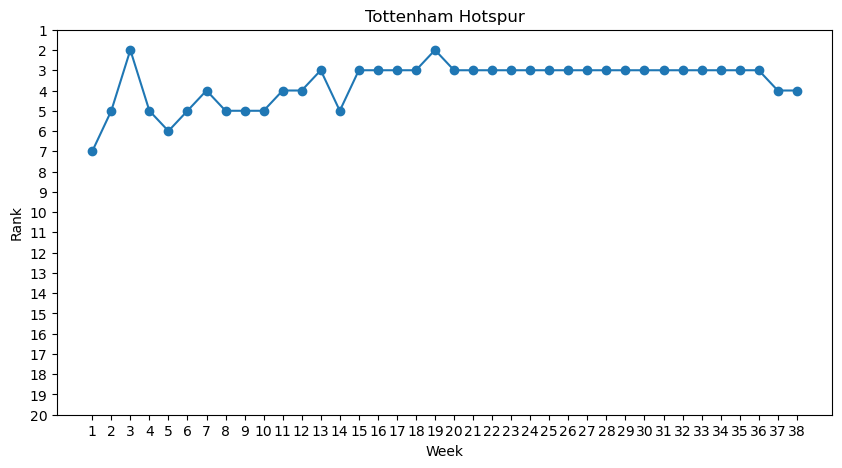

----------------------------------------------------
시즌 득점왕                       full_name Current Club  goals_overall
Rank                                                       
1                    Sadio Mané    Liverpool             22
1     Pierre-Emerick Aubameyang      Arsenal             22
1                 Mohamed Salah    Liverpool             22
----------------------------------------------------

----------------------------------------------------
시즌 도움왕         full_name Current Club  assists_overall
Rank                                           
1     Eden Hazard      Chelsea               15
----------------------------------------------------



In [28]:
m = matches_anl(matches)
print(m.team_points(), end="\n\n")
m.team_rank_graph()

p = players_anl(players)

top_scorer = p.top_scorer()
print('----------------------------------------------------')
print('시즌 득점왕 {}'.format(top_scorer))
print('----------------------------------------------------\n')
top_assister = p.top_assister()
print('----------------------------------------------------')
print('시즌 도움왕 {}'.format(top_assister))
print('----------------------------------------------------\n')

In [ ]:
# home: 홈골이 많은 top n / away: 어웨이골이 많은 top n / total: 통합골이 많은 top n / n: 몇순위까지인지 
home, away, total, n = p.most_goal_team()
print('----------------------------------------------------')
print('|Home Goal Top{}|'.format(n))
print(home)
print('----------------------------------------------------')
print('|Away Goal Top{}|'.format(n))
print(away)
print('----------------------------------------------------')
print('|Goal Overall Top{}|'.format(n))
print(total)
print('----------------------------------------------------')